In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import glob
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly
from scipy.stats import chisquare
from collections import OrderedDict


In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

In [4]:
1*np.erf(0.5)

0.5204998778130465

In [5]:
def funcG(t,t0,sig,a,c):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def funcA(t,t0,sig,a,c):
    tau = 157.5e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2.)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

In [6]:
def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 200*25
    cut2=cut-100*25
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]
    

    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi,[Arr-cut2,Arr+cut]

In [7]:
def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger+1e3)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400*25
    #cut2=cut-50
    cut2=cut-100*25
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]

    #fitval = [XX[Arr],BF, miny,Off,120e-6]
    #optim,eh = optimize.curve_fit(func,fitX,fitY,p0=fitval)
    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    #chi = sum((func(fitX,*optim)- fitY)**2)
    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi,[Arr-cut2,Arr+cut]

In [20]:
def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off,130e-3]
    cut = 200*25
    cut2=cut-100*25
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]
    

    optim,eh = optimize.curve_fit(func,fitX,fitY,p0=fitval)

    chi = sum((func(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi,[Arr-cut2,Arr+cut]

def FITTER_ANOD(x,y):# V2
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    

    miny = min(yy[10000:])

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400*25
    #cut2=cut-50
    cut2=cut-100*25
    #if XX[Arr-cut2:Arr+cut].shape[0]!=0:
    #    fitX = XX[Arr-cut2:Arr+cut]
    #    fitY = YY[Arr-cut2:Arr+cut]
    #else:
    #    fitX = XX[0:Arr+cut]
    #    fitY = YY[0:Arr+cut]
    fitX = XX#[Arr-cut2:Arr+cut]
    fitY = YY#[Arr-cut2:Arr+cut]
    #fitval = [XX[Arr],BF, miny,Off,120e-6]
    #optim,eh = optimize.curve_fit(func,fitX,fitY,p0=fitval)
    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    #chi = sum((func(fitX,*optim)- fitY)**2)
    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi,[Arr-cut2,Arr+cut]

In [17]:
def gaus(x,x0,sigma,a,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+c

In [14]:
PATH = '/Users/austinmcdonald/Desktop/ArgonXenon/'
#PATH = '/Users/austinmcdonald/Desktop/HeliumXenonV2/'

#PATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'

folders = glob.glob(PATH+"*/")
folders.sort()
#folders = [folders[0]]
folders = [folders[2]]
folders

['/Users/austinmcdonald/Desktop/ArgonXenon/099/']

In [19]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
MARKER= dict()
CHIa = []
CHIg = []
for F in range(0,len(folders)):
    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    MarkH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    N = 0
    for fi in files:
        
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(np.nan_to_num(Data[0]))!=0 and np.mean(np.nan_to_num(Data[1]))!=0:
            xa,ya,opta,chia,cuta = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig,cutg = FITTER_GOLD(Data[0],Data[1])
            CHIa.append(chia)
            CHIg.append(chig)
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            
            print(optg[0])
            '''#plt.plot(xa[cuta[0]:cuta[1]],ya[cuta[0]:cuta[1]])
            plt.plot(xa,ya)
            plt.plot(xa[cuta[0]:cuta[1]],ya[cuta[0]:cuta[1]],color='r')
            plt.plot(xa,funcA(xa,*opta))
            #plt.xlim(0,0.0008)
            plt.show()
            
            #plt.plot(xg[cutg[0]:cutg[1]],yg[cutg[0]:cutg[1]])
            plt.plot(xg,yg)
            plt.plot(xg[cutg[0]:cutg[1]],yg[cutg[0]:cutg[1]],color='r')
            plt.plot(xg,funcA(xg,*optg))
            plt.xlim(0,0.0002)
            #plt.xlim(0.00004,0.00005)
            plt.show()'''
            if PP==1:
                PP = info[0]
                MarkH.append('<')
            elif PP==3:
                PP = info[1]
                MarkH.append('D')
            elif PP==6:
                PP = info[2]
                MarkH.append('s')
            elif PP==9:
                PP = info[3]
                MarkH.append('o')
            elif PP==11 or PP==10:
                PP = info[4]
                MarkH.append('^')
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
    MARKER[F] = np.array(MarkH)  
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct
#def funcA(t,t0,sig,a,c):

Ar-099_P-01_E-050.txt
7.497139609797103e-06
Ar-099_P-01_E-100.txt
7.432667759032943e-06
Ar-099_P-01_E-150.txt
7.3785881363302125e-06
Ar-099_P-01_E-200.txt
7.311152360458438e-06
Ar-099_P-01_E-250.txt
7.248016240155924e-06
Ar-099_P-01_E-300.txt
7.17239350132367e-06
Ar-099_P-03_E-050.txt
7.846490451432121e-06
Ar-099_P-03_E-100.txt
7.816523861963257e-06
Ar-099_P-03_E-150.txt
7.786230935853954e-06
Ar-099_P-03_E-200.txt
7.817923729904672e-06
Ar-099_P-03_E-250.txt
7.794294262002272e-06
Ar-099_P-03_E-300.txt
7.801057834908956e-06
Ar-099_P-06_E-050.txt
8.19063478633589e-06
Ar-099_P-06_E-100.txt
8.15629197539704e-06
Ar-099_P-06_E-150.txt
8.130701451810394e-06
Ar-099_P-06_E-200.txt
8.113805811813369e-06
Ar-099_P-06_E-250.txt
8.089011753904914e-06
Ar-099_P-06_E-300.txt
8.067451792599208e-06
Ar-099_P-09_E-050.txt
8.37487764324446e-06
Ar-099_P-09_E-100.txt
8.330929333406642e-06
Ar-099_P-09_E-150.txt
8.305917078047673e-06
Ar-099_P-09_E-200.txt
8.28360080273655e-06
Ar-099_P-09_E-250.txt
8.257678022125

In [ ]:
#def funcA(t,t0,sig,a,c):
ANODE[0][:,2]*1e6

In [41]:
EFID[0][EFID[0]==300]

array([300, 300, 300, 300])

In [37]:
sigma = ANODE[0][:,1]*1e6
height = ANODE[0][:,2]*1e6


In [43]:
PRE[0][EFID[0]==300]

array([1.06, 3.04, 6.04, 9.07])

In [42]:
sigma[EFID[0]==300]*height[EFID[0]==300]

array([-2797.94584004, -1517.54122961, -1155.00163622,  -984.80030704])

In [21]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
MARKER= dict()
CHIa = []
CHIg = []
for F in range(0,len(folders)):
    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    MarkH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    N = 0
    for fi in files:
        
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(np.nan_to_num(Data[0]))!=0 and np.mean(np.nan_to_num(Data[1]))!=0:
            xa,ya,opta,chia,cuta = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig,cutg = FITTER_GOLD(Data[0],Data[1])
            CHIa.append(chia)
            CHIg.append(chig)
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            
            print(optg[0])
            '''#plt.plot(xa[cuta[0]:cuta[1]],ya[cuta[0]:cuta[1]])
            plt.plot(xa,ya)
            plt.plot(xa[cuta[0]:cuta[1]],ya[cuta[0]:cuta[1]],color='r')
            plt.plot(xa,funcA(xa,*opta))
            #plt.xlim(0,0.0008)
            plt.show()
            
            #plt.plot(xg[cutg[0]:cutg[1]],yg[cutg[0]:cutg[1]])
            plt.plot(xg,yg)
            plt.plot(xg[cutg[0]:cutg[1]],yg[cutg[0]:cutg[1]],color='r')
            plt.plot(xg,func(xg,*optg))
            plt.xlim(0,0.0002)
            #plt.xlim(0.00004,0.00005)
            plt.show()'''
            if PP==1:
                PP = info[0]
                MarkH.append('<')
            elif PP==3:
                PP = info[1]
                MarkH.append('D')
            elif PP==6:
                PP = info[2]
                MarkH.append('s')
            elif PP==9:
                PP = info[3]
                MarkH.append('o')
            elif PP==11 or PP==10:
                PP = info[4]
                MarkH.append('^')
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
    MARKER[F] = np.array(MarkH)  
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct
#def funcA(t,t0,sig,a,c):

Ar-099_P-01_E-050.txt
7.434022883085967e-06
Ar-099_P-01_E-100.txt
7.370671077947711e-06
Ar-099_P-01_E-150.txt
7.318319097113084e-06
Ar-099_P-01_E-200.txt
7.251189484654932e-06
Ar-099_P-01_E-250.txt
7.189795267915571e-06
Ar-099_P-01_E-300.txt
7.113723357827118e-06
Ar-099_P-03_E-050.txt
7.767540087342418e-06
Ar-099_P-03_E-100.txt
7.739999043507626e-06
Ar-099_P-03_E-150.txt
7.711677590525616e-06
Ar-099_P-03_E-200.txt
7.74329836083697e-06
Ar-099_P-03_E-250.txt
7.72229925953662e-06
Ar-099_P-03_E-300.txt
7.728614330482306e-06
Ar-099_P-06_E-050.txt
8.094711386440668e-06
Ar-099_P-06_E-100.txt
8.062682176740284e-06
Ar-099_P-06_E-150.txt
8.038455807744347e-06
Ar-099_P-06_E-200.txt
8.024837593294922e-06
Ar-099_P-06_E-250.txt
8.000038142846557e-06
Ar-099_P-06_E-300.txt
7.981162886459766e-06
Ar-099_P-09_E-050.txt
8.268129617807597e-06
Ar-099_P-09_E-100.txt
8.228958660271543e-06
Ar-099_P-09_E-150.txt
8.207114285663323e-06
Ar-099_P-09_E-200.txt
8.182448501600573e-06
Ar-099_P-09_E-250.txt
8.1629517783

In [156]:
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

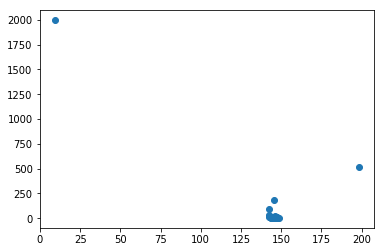

In [160]:
q = ANODE[0][:,4]*1e6
w = (ANODE[0][:,1]*1e6)**2

plt.scatter(q,w)
#plt.xlim(125,175)

In [27]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
from collections import OrderedDict
import matplotlib.patches as mpatches


In [28]:
nextDX = np.array([22.9,25.9,26.2,28.0,28.3,28.4,29.9,33.2,34.0,37.9,38.0,38.3,42.0,43.4,44.4,47.5,48.6,53.7,57.0])
nextDY = np.array([1357.3, 1213.3, 1167.4, 1161.1, 1320.9, 1195.9, 1105.7, 1058.2, 1034.5, 979.1, 1129.4,
          988.6, 941.1, 939.6, 958.5, 1028.2, 901.6, 869.9, 903.2])
print(len(nextDX))
print(len(nextDY))

19
19


In [65]:
r = mpatches.Patch(color='r',    label='0%Xe',alpha=0.6)
k = mpatches.Patch(color='k',    label='100%Ar',alpha=0.6)
b = mpatches.Patch(color='b',    label='100%Ar',alpha=0.6)

In [66]:
PRE[0]

array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 3.05, 3.05, 3.05, 3.05, 3.05,
       3.05, 6.03, 6.03, 6.03, 6.03, 6.03, 6.03, 8.98, 8.98, 8.98, 8.98])

<Figure size 576x576 with 0 Axes>

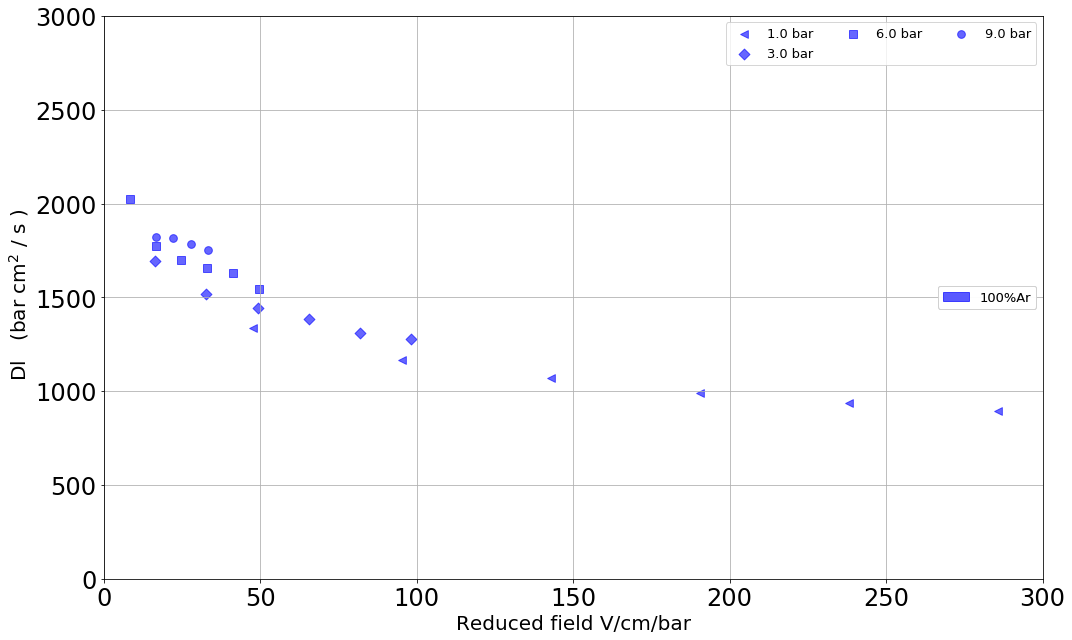

In [67]:
plt.figure(figsize=(8,8))
plt.figure(figsize=(15,9))

#for q in range(0,len(GOLDD)):
#for q in range(0,7):
#for q in [0,1,2]:
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #d = 13.48+.16+.398

    sigma = (ANODE[q][:,1]*1e6)**2
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*1e6*PRE[q]
    Dstar  = np.sqrt(2*Dslash/V)
    
    lab = PERCT[q]+'%Ar'
    color = COL[q]
    LABB = np.rint(PRE[q]).astype(str)

    Err = np.sqrt((0.1/sigma)**2+(0.5/Dt)**2+(0.1/d)**2)
    X = REDU[q]
    Y = Dslash
    mark = MARKER[q]
    for x, y, m ,L in zip(X, Y, mark, LABB):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60,label=L+' bar') 
        
    #plt.errorbar(X,Y,xerr=0,yerr=Y*Err,ecolor='k',color='k',fmt='o', capthick=1)
#plt.scatter(nextDX,nextDY,color='lime')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
legend2=plt.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=3,fontsize=13)

legend1=plt.legend(handles=[b],loc='center right',ncol=5,fontsize=13)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)


#plt.ylim(600,1600)
#plt.semilogx()
plt.ylim(0,3000)
plt.xlim(0,300)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.xlabel("Reduced field V/cm/bar",fontsize=20)
plt.ylabel(r" Dl   (bar cm$^2$ / s )",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [167]:
'''XXX= np.array([  4.22222222,   5.62962963,   8.44444444,   8.44444444,
         8.44444444,  11.25925926,  12.66666667,  16.88888889,
        16.88888889,  16.88888889,  22.51851852,  25.33333333,
        25.33333333,  25.33333333,  28.14814815,  33.77777778,
        33.77777778,  33.77777778,  42.22222222,  50.66666667,
        50.66666667,  50.66666667,  67.55555556,  76.        ,
        84.44444444, 101.33333333, 101.33333333, 152.        ,
       202.66666667, 253.33333333, 304.        ])

YYY = np.array([1978.50192964, 1885.10623935, 1620.19645661, 1620.19585484,
       1620.19536572, 1494.5721786 , 1440.85715134, 1423.53916396,
       1358.7255811 , 1358.72525693, 1376.01096939, 1287.07611075,
       1287.07560617, 1287.07590654, 1279.69395658, 1226.64214252,
       1226.64345548, 1148.29227858, 1146.04810718, 1095.09421114,
       1100.53526527, 1095.09355084,  929.24556235,  925.16267209,
        957.86288099,  875.23708382,  875.23641169,  830.08939517,
        713.51498449,  713.61233762,  639.63588095])'''

XXX = np.array([  2.81481481,   8.44444444,  11.25925926,  14.07407407,
        16.88888889,  16.88888889,  19.7037037 ,  22.51851852,
        25.33333333,  25.33333333,  25.33333333,  28.14814815,
        30.96296296,  33.77777778,  33.77777778,  36.59259259,
        39.40740741,  42.22222222,  50.66666667,  50.66666667,
        67.55555556,  76.        ,  76.        ,  84.44444444,
        92.88888889, 101.33333333, 101.33333333, 109.77777778,
       118.22222222, 126.66666667, 152.        , 177.33333333,
       202.66666667, 228.        , 253.33333333, 278.66666667,
       304.        , 329.33333333, 354.66666667])

YYY = np.array([1208.06192218, 2622.65751253, 2782.95341178, 2206.5801764 ,
       1937.13155241, 1786.7293096 , 1755.76267449, 1640.18762347,
       1554.09864953, 1286.00538177, 1255.35170092, 1466.20069551,
       1340.51979375, 1317.31597365, 1097.89365663, 1255.98052266,
       1216.46309979,  980.49761083,  944.75521303,  944.75548585,
        839.0146336 ,  852.51141004,  857.82787085,  788.13940045,
        762.72931377,  767.01193198,  748.96443736,  739.68335622,
        723.59901912,  684.07559719,  645.78502241,  606.08680087,
        623.39578972,  618.5271399 ,  592.71763353,  572.45328186,
        556.26782759,  552.70947142,  540.25919839])

In [133]:
sigma

array([2.70290009, 1.41780608, 0.98417509, 0.75197759, 0.6154162 ,
       0.52387368, 2.81691429, 1.46897363, 1.01174272, 0.7826218 ,
       0.62736262, 0.53509365, 2.92015683, 1.51832519, 1.04943112,
       0.81454148, 0.66981719, 0.55286363, 1.05162293, 0.83368359,
       0.68496913, 0.57998242])

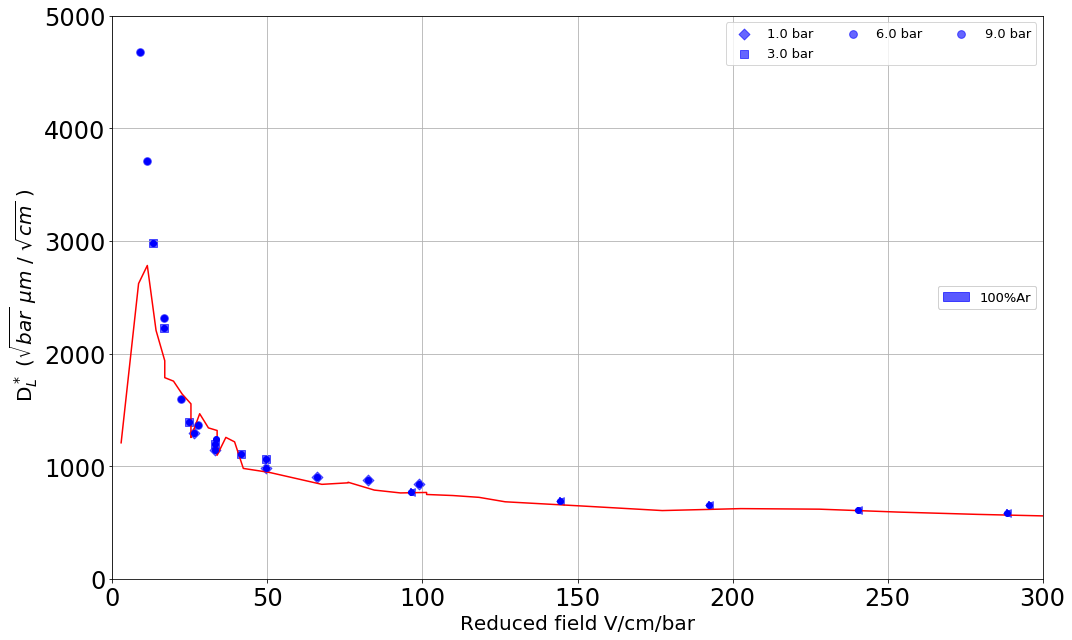

In [172]:
plt.figure(figsize=(15,9))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
#for q in [0,1,2]:
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    #Dt = (ANODE[q][:,0] )*1e6
    d = 15.12
    d = 13.48
    d = 14.128
    sigma = (ANODE[q][:,1]*1e6)**2
    #sigma = sigma/2
    V = d/Dt
    V = V
    V = V
    Dslash = sigma*V**3/(2*d)*1e6*PRE[q]
    Dstar  = np.sqrt(2*Dslash/V)#*np.sqrt(PRE[q])
    
    A = sigma*V**2*PRE[q]*1e6/d
    B = (0.05/(2*sigma))**2+(0.5/Dt)**2+(0.1/(2*d))**2+(0.1/(2*PRE[q]))**2
    DeltaD = np.sqrt((A)*(B))
    
    
    lab = PERCT[q]+'%Ar'
    color = COL[q]
    ABB = np.rint(PRE[q]).astype(str)
    
    X = REDU[q]
    Err = X*np.sqrt((2/EFID[q])**2+(0.1/(PRE[q]))**2)
    Y = Dstar*10#*0.85
    mark = MARKER[q]
    for x, y, m ,L in zip(X, Y, mark, LABB):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60,label=L+' bar') 
        
    plt.errorbar(X,Y,xerr=0,yerr=DeltaD*10,ecolor=color,color=color,fmt='o', capthick=1)
plt.plot(XXX,YYY,color='r')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
legend2=plt.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=3,fontsize=13)

legend1=plt.legend(handles=[b],loc='center right',ncol=5,fontsize=13)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)


#plt.ylim(0,1000)
#plt.xlim(0,200)
#plt.xlim(0,400)
#plt.axhline(500)
plt.ylim(0,5000)
#plt.semilogx()
plt.xlim(0,300)
#plt.ylim(600,2000)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field V/cm/bar",fontsize=20)
plt.ylabel(r" D$^*_L$ ($\sqrt{bar}$ $\mu m$ / $\sqrt{cm}$ )",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [173]:
Dt

array([134.43106804, 125.56025257, 119.16245524, 114.12900933,
       109.99017916, 172.07070449, 164.01420767, 152.71647335,
       145.23142479, 139.17195619, 133.64273446, 276.07260419,
       214.17214838, 175.73195835, 164.54089328, 158.14575156,
       153.56042678, 640.65850552, 388.574391  , 214.18108015,
       181.76967285, 170.08594494, 163.92790494])

In [174]:
sigma

array([  7.29771901,   5.1738611 ,   4.17070088,   3.31011821,
         2.83634699,  11.53744807,   8.28382443,   5.26719111,
         4.04224277,   3.47147264,   2.932241  ,  79.17434038,
        26.68532956,   6.99467435,   4.52289784,   3.61060729,
         3.12267566, 705.69472349, 163.72174284,  19.29516837,
         6.64418298,   4.26184807,   3.24490069])

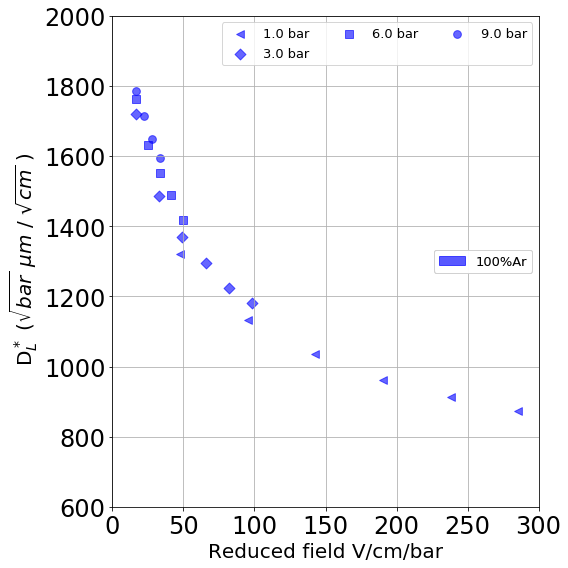

In [114]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
#for q in [0,1,2]:
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    #Dt = (ANODE[q][:,0] )*1e6
    d = 15.12
    d = 13.48
    d = 14.128
    sigma = (ANODE[q][:,1]*1e6)**2-0.0125
    V = d/Dt
    V = V
    V = V*1.075
    Dslash = sigma*V**3/(2*d)*1e6*PRE[q]
    Dstar  = np.sqrt(2*Dslash/V)#*np.sqrt(PRE[q])
    
    lab = PERCT[q]+'%Ar'
    color = COL[q]
    ABB = np.rint(PRE[q]).astype(str)
    
    Err = np.sqrt((0.1/sigma)**2+(0.5/Dt)**2+(0.1/d)**2)
    X = REDU[q]
    Y = Dstar*10
    mark = MARKER[q]
    for x, y, m ,L in zip(X, Y, mark, LABB):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60,label=L+' bar') 
        
plt.plot(XXX,YYY,color='r')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
legend2=plt.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=3,fontsize=13)

legend1=plt.legend(handles=[b],loc='center right',ncol=5,fontsize=13)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.xlim(0,300)
plt.ylim(600,2000)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field V/cm/bar",fontsize=20)
plt.ylabel(r" D$^*_L$ ($\sqrt{bar}$ $\mu m$ / $\sqrt{cm}$ )",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [70]:
(ANODE[q][:,0])*1e6-GOLDD[q][:,0]*1e6

array([ 72.76401596,  61.40655504,  55.94278275,  52.524264  ,
        50.07382848,  48.19637354,  97.30265557,  81.21239665,
        73.00595689,  67.90492111,  64.2685566 ,  61.46841257,
       116.461225  ,  97.85794867,  87.83238331,  81.34096894,
        76.68895615,  73.17274909,  98.04328208,  90.82997622,
        85.53609223,  81.39995913])

In [71]:
GOLDD[q][:,0]*1e6

array([7.29507801, 7.35304305, 7.42578237, 7.47907842, 7.51587732,
       7.52862019, 7.99182288, 7.91723321, 7.93442673, 7.89321157,
       7.88173969, 7.90393245, 8.19293563, 8.15117104, 8.20769867,
       8.19379229, 8.17753895, 8.09091899, 8.32711719, 8.28317444,
       8.28103119, 8.30433241])

In [125]:
XXX = np.array([  4.60606061,   5.62962963,   7.36969697,   8.44444444,
         9.00740741,   9.21212121,  11.25925926,  13.51111111,
        13.81818182,  18.42424242,  22.51851852,  23.03030303,
        25.33333333,  27.02222222,  27.63636364,  28.14814815,
        36.84848485,  42.22222222,  45.03703704,  50.66666667,
        50.66666667,  50.66666667,  81.06666667,  84.44444444,
       101.33333333, 101.33333333, 135.11111111, 152.        ,
       152.        , 202.66666667, 253.33333333, 304.        ,
       304.        , 405.33333333, 608.        ])

YYY = np.array([1.063, 1.115, 1.197, 1.231, 1.251, 1.25 , 1.332, 1.397, 1.386,
       1.529, 1.613, 1.608, 1.66 , 1.68 , 1.698, 1.716, 1.825, 1.899,
       1.935, 1.989, 1.989, 1.98 , 2.25 , 2.261, 2.374, 2.374, 2.593,
       2.642, 2.623, 2.819, 2.963, 3.071, 3.088, 3.274, 3.586])

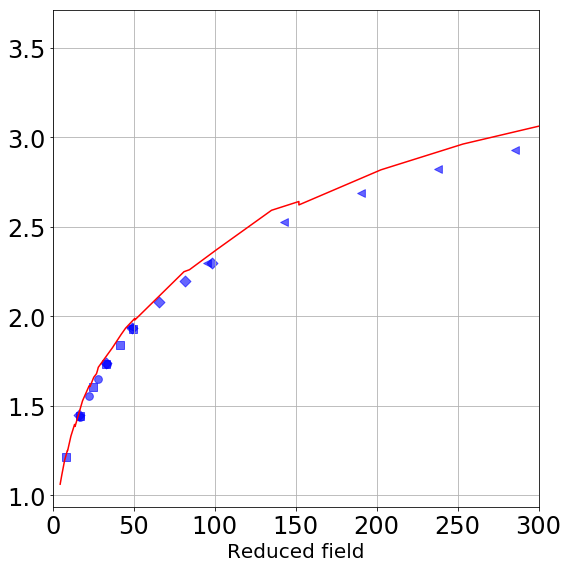

In [127]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    #Dt = (ANODE[q][:,0])*1e6
    d = 15.12
    d = 14.128
    #d=13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    V = d/Dt
    lab = PERCT[q]+'%Ar'
    color = COL[q]
    
    #plt.scatter(REDU[q]*1.06-8,Dslash,label=lab,s=40,color='r',alpha=0.6)
    #RR = ((3125*.16+EFID[q]*13.48)/d)/PRE[q]
    #plt.scatter(RR,V*10,label=lab,s=4,color='b',alpha=0.6)
    #mark = Mark(REDU[q],PRE[q])
    X = REDU[q]
    Y = (V*10)#*1.075
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY,color='lime')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')
plt.plot(XXX,YYY,color='r')


#plt.ylim(0,1000)
#plt.xlim(0,200)
#plt.xlim(0,400)
#plt.axhline(500)
#plt.ylim(0,2)
plt.xlim(0,300)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [36]:
V*10

array([1.85256405, 2.19520538, 2.40960484, 2.56643292, 2.69202504,
       2.79689093, 1.38536815, 1.65984512, 1.84642467, 1.98512859,
       2.09744869, 2.19299628, 1.15746679, 1.3775069 , 1.53474146,
       1.65722147, 1.75774983, 1.84221588, 1.37490297, 1.48409155,
       1.57594293, 1.65602049])

In [37]:
PRE[q]

array([1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 3.05, 3.05, 3.05, 3.05, 3.05,
       3.05, 6.03, 6.03, 6.03, 6.03, 6.03, 6.03, 8.98, 8.98, 8.98, 8.98])

In [38]:
Dt

array([ 72.76401596,  61.40655504,  55.94278275,  52.524264  ,
        50.07382848,  48.19637354,  97.30265557,  81.21239665,
        73.00595689,  67.90492111,  64.2685566 ,  61.46841257,
       116.461225  ,  97.85794867,  87.83238331,  81.34096894,
        76.68895615,  73.17274909,  98.04328208,  90.82997622,
        85.53609223,  81.39995913])

In [39]:
ANODE[q][:,1]*1e6

array([2.32503767, 1.6839276 , 1.40297904, 1.2263585 , 1.10942886,
       1.02359531, 2.37356874, 1.71404412, 1.42249269, 1.25109696,
       1.12014519, 1.03449857, 2.41667409, 1.74259874, 1.44874506,
       1.27635534, 1.15742576, 1.05153567, 1.45025717, 1.29126572,
       1.17044362, 1.07701664])

In [40]:
GOLDD[q][:,1]*1e6

array([0.60803479, 0.69469084, 0.67436724, 0.64197777, 0.64073731,
       0.72911277, 0.80206631, 0.71596293, 0.81398371, 0.72047875,
       0.72960044, 0.82767922, 0.96494776, 1.58578487, 1.03931792,
       1.1074242 , 1.03145028, 1.00905147, 0.91451833, 0.87694183,
       0.90786562, 1.15580379])

/Users/austinmcdonald/miniconda/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


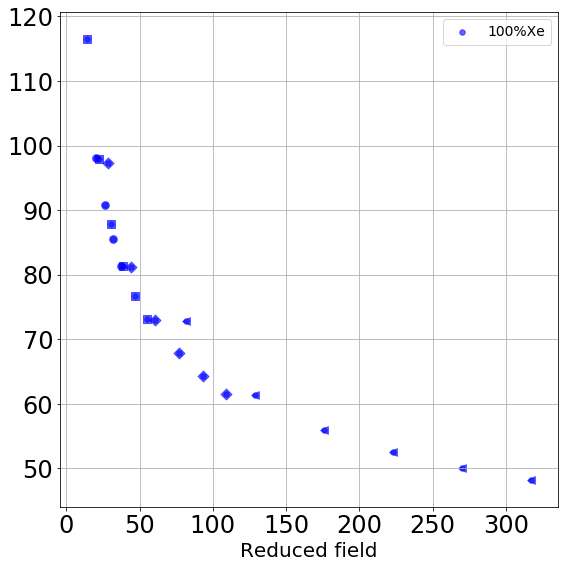

In [41]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = ((((ANODE[q][:,1]*1e6))**2)) - (((GOLDD[q][:,1]*1e6))**2)
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*PRE[q]*1e6
    Dstar  = np.sqrt(2*Dslash/V)*np.sqrt(PRE[q])
    
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    
    RR = ((500+EFID[q]*d)/13.64)/PRE[q]
    plt.scatter(RR,Dt,label=lab,s=30,color='b',alpha=0.6)
    
    X = RR
    Y = Dt
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60)
    
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = ((((ANODE[q][:,1]*1e6))**2))# - (((GOLDD[q][:,1]*1e6))**2)
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*PRE[q]*1e6
    Dstar  = np.sqrt(2*Dslash/V)*np.sqrt(PRE[q])
    
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    
    RR = ((500+EFID[q]*d)/13.64)/PRE[q]

    plt.scatter(REDU[q],sigma*(PRE[q]),label=lab,s=30,color='b',alpha=0.6)
    plt.scatter(RR,sigma*(PRE[q]),label=lab,s=30,color='r',alpha=0.6)

    '''X = RR
    Y = Dt
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60)'''
    
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = ((((ANODE[q][:,1]*1e6))**2)) - (((GOLDD[q][:,1]*1e6))**2)
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*PRE[q]*1e6
    Dstar  = np.sqrt(2*Dslash/V)*np.sqrt(PRE[q])
    
    #D = (sigma*d**2)/(2.0*Dt**3)*1e6
    #Dstar = np.sqrt(PRE[q]*sigma*d)/Dt
    #mark = Mark(REDU[q],PRE[q])
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    #plt.scatter(REDU[q]*1.06-8,Dslash,label=lab,s=40,color='r',alpha=0.6)
    RR = ((500+EFID[q]*d)/13.64)/PRE[q]
    plt.scatter(RR,V*10,label=lab,s=4,color='b',alpha=0.6)
    #mark = Mark(REDU[q],PRE[q])
    X = REDU[q]
    Y = V*10
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY,color='lime')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')


#plt.ylim(0,1000)
#plt.xlim(0,200)
#plt.xlim(0,400)
#plt.axhline(500)
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
ReduCor = ((500+EFID[q]*d)/13.64)/PRE[q]
X = ReduCor
V = 13.48/((ANODE[q][:,0] - GOLDD[q][:,0])*1e6)
V = V*10
plt.scatter(X,V)

xt = np.linspace(1,5000,5000)
cof = np.polyfit(X,X*V,2)
fit = np.poly1d(cof)

plt.plot(xt,fit(xt)/xt,'--r')


plt.xlim(0,500)
plt.ylim(0,5)
plt.show()


### 

In [ ]:
dex = []
for x in range(0,len(ReduCor)):
    fn = find_nearest(xt,3125/PRE[0][x])
    loc = np.where(xt==fn)[0][0]
    dex.append(loc)
dex = np.array(dex)

dex2 = []
for x in range(0,len(ReduCor)):
    fn = find_nearest(xt,300/PRE[0][x])
    loc = np.where(xt==fn)[0][0]
    dex2.append(loc)
dex2 = np.array(dex2)

In [ ]:
sig = ((ANODE[0][:,1]*1e6))**2 - ((GOLDD[0][:,1]*1e6))**2
Dt = (ANODE[0][:,0] - GOLDD[0][:,0])*1e6
vv = 15.12/Dt

xxt = np.linspace(0,300,1000)

xx = 1/(fit(xt[dex])/xt[dex])
xx = (1/(fit(xt[dex])/xt[dex]))**2

here = np.where((xx >= 0) & (xx <=300))
yy = ((ANODE[0][:,1]*1e6))**2
print(min(yy))
plt.scatter(xx[here],yy[here],label="anode")

coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))


xx = 4/(fit(xt[dex2])/xt[dex2])
xx = (4/(fit(xt[dex2])/xt[dex2]))**2
here = np.where((xx >= 0) & (xx <=200))
yy = ((GOLDD[0][:,1]*1e6))**2
print(min(yy))

plt.scatter(xx[here],yy[here],label="gold")
coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))

'''xxt = np.linspace(0,0.002,1000)
xx = 1/fit(xt[dex])/xt[dex]
yy = ((ANODE[6][:,1]*1e6))**2

coff = np.polyfit(xx,yy,2)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
plt.ylim(0,6)
plt.xlim(0,10)
plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [ ]:
sigma

In [ ]:
EP = np.linspace(1,1000,10000)


sort_index = np.argsort(REDU[6])
Redu = REDU[6][sort_index]
sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) - (((GOLDD[q][:,1]*1e6))**2-2.58)
sigma = ((((ANODE[q][:,1]*1e6))**2)-0)# - (((GOLDD[q][:,1]*1e6))**2-2.58)


plt.scatter(Dt[0:4],sigma[0:4],label=lab,s=30,color='g',alpha=0.6)
cof1 = np.polyfit(Dt[0:4],sigma[0:4],1)
print(cof1)
fit1 = np.poly1d(cof1)
plt.plot(EP,fit1(EP),':g')

plt.scatter(Dt[4:8],sigma[4:8],label=lab,s=30,color='b',alpha=0.6)
cof1 = np.polyfit(Dt[4:8],sigma[4:8],1)
print(cof1)
fit1 = np.poly1d(cof1)
plt.plot(EP,fit1(EP),':b')

'''

Y    = (sigma*PRE[6])[sort_index]
#Y    = (sigma)[sort_index]
#drop = np.argwhere(np.isnan(Y))
Redu = Redu[~np.isnan(Y)]
Y    = Y[~np.isnan(Y)]

#plt.scatter(1000/Redu,Y,label=lab,s=30,color='g',alpha=0.6)
plt.scatter(Redu,1/(Y*Redu),label=lab,s=30,color='g',alpha=0.6)
cof = np.polyfit(1000/Redu,Y,4)
fit = np.poly1d(cof)
'''
#plt.plot(EP,fit(1000/EP),':r')
plt.xlim(0,200)
#plt.ylim(0,200)

In [ ]:
PRE[6][4:8]

In [ ]:
sigma[4:8]

In [ ]:
EP = np.linspace(1,200,1000)


sort_index = np.argsort(REDU[6])
Redu = REDU[6][sort_index]
sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) - (((GOLDD[q][:,1]*1e6))**2-2.58)
Y    = (sigma*PRE[6])[sort_index]
#Y    = (sigma)[sort_index]
#drop = np.argwhere(np.isnan(Y))
Redu = Redu[~np.isnan(Y)]
Y    = Y[~np.isnan(Y)]

#plt.scatter(1000/Redu,Y,label=lab,s=30,color='g',alpha=0.6)
plt.scatter(Redu,1/(Y*Redu),label=lab,s=30,color='g',alpha=0.6)
cof = np.polyfit(1000/Redu,Y,4)
fit = np.poly1d(cof)

#plt.plot(EP,fit(1000/EP),':r')
#plt.xlim(0,.20)
#plt.ylim(-20,200)

In [ ]:
Y

In [ ]:
[~np.isnan(Y)]

In [ ]:
Y[~np.isnan(Y)]

In [ ]:
sig1 = ((ANODE[6][:,1]*1e6))**2 - 0
sig2 = ((ANODE[6][:,1]*1e6))**2 - 6.82
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

X,Y = DlP(REDU[6],sig1,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)
X,Y = DlP(REDU[6],sig2,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='k',alpha=0.6)

In [ ]:
sig1 = (ANODE[6][:,1]*1e6)**2
sig2 = (GOLDD[6][:,1]*1e6)**2
sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

D = sig/(2*Dt)
frac_err = np.sqrt((2*1/sig1)**2+(2*1/sig2)**2+(2*1/Dt)**2)
frac_err = D*frac_err
#X,Y = DlP(Dt,sig,Dt,PRE[6])
plt.scatter(REDU[6],D,label=lab,s=40,color='r',alpha=0.6)
plt.errorbar(REDU[6],D,yerr=frac_err,fmt='D', capthick=1,markersize=0)
plt.ylim(0,0.4)
#for x, y, m in zip(X, Y, mark):
#        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 


In [ ]:
def DlSstar(Redu, sigma, time, pre):
    d = 15.12
    d = 13.49
    D = (sigma*d**2)/(2.*time**3)*1e6 # Dl slash
    D = 2.*D/(d/(time*1e-6))
    D = np.sqrt(D)*np.sqrt(pre)
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

In [ ]:
sig1 = (ANODE[6][:,1]*1e6)**2
sig2 = (GOLDD[6][:,1]*1e6)**2
sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

D = sig*(15.12)**2/(2*Dt**3)*PRE[6]
#D = np.sqrt(D)*1e4/2
#D = 2*D/(15.12/(Dt*1e-6))
frac_err = np.sqrt((2*0.5/sig1)**2+(2*0.5/sig2)**2+(6*0.5/Dt)**2+(2*0.1/15)**2)
frac_err = D*frac_err
#X,Y = DlP(Dt,sig,Dt,PRE[6])
plt.scatter(REDU[6],D,label=lab,s=40,color='r',alpha=0.6)
plt.errorbar(REDU[6],D,yerr=frac_err,fmt='D', capthick=1,markersize=0)
plt.semilogx()
#plt.ylim(0,0.004)
#for x, y, m in zip(X, Y, mark):
#        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 


In [ ]:
sig1 = (ANODE[0][:,1]*1e6)**2
sig2 = (GOLDD[0][:,1]*1e6)**2
sig = ((ANODE[0][:,1]*1e6))**2 -((GOLDD[0][:,1]*1e6))**2
Dt = (ANODE[0][:,0] - GOLDD[0][:,0])*1e6

D = sig*(15.12)/(Dt**2)*PRE[0]
D = np.sqrt(D)*1e4
#D = 2*D/(15.12/(Dt*1e-6))
frac_err = np.sqrt((2*0.5/sig1)**2+(2*0.5/sig2)**2+(2*0.5/Dt)**2+(0.1/15)**2)
frac_err = D*frac_err
#X,Y = DlP(Dt,sig,Dt,PRE[6])
plt.scatter(REDU[0],D,label=lab,s=40,color='r',alpha=0.6)
plt.errorbar(REDU[0],D,yerr=frac_err,fmt='D', capthick=1,markersize=0)
plt.semilogx()
#plt.ylim(0,0.004)
#for x, y, m in zip(X, Y, mark):
#        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 


In [ ]:
sig1 = ((ANODE[6][:,1]*1e6))**2 - 0
sig2 = ((ANODE[6][:,1]*1e6))**2 - 6.82
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

X,Y = DlP(REDU[6],sig1,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)
X,Y = DlP(REDU[6],sig2,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='k',alpha=0.6)

In [ ]:
sig1 = ((ANODE[6][:,1]*1e6))**2 - 0
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

X,Y = DlP(REDU[6],sig1,Dt,PRE[6])

xt = np.linspace(1,200,1000)
cof = np.polyfit(X,X**2*Y,4)
fit = np.poly1d(cof)
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)

plt.plot(xt,fit(xt)/xt**2)
plt.ylim(0,5)


In [ ]:
X,V = Vel(REDU[6],Dt)

plt.scatter(X,V)

xt = np.linspace(1,500,1000)
cof = np.polyfit(X,X*V,2)
fit = np.poly1d(cof)

plt.plot(xt,fit(xt)/xt,'--r')


plt.xlim(0,500)
plt.ylim(0,1.5)
plt.show()


In [ ]:
((ANODE[6][:,1]*1e6))#**2

In [ ]:
((GOLDD[6][:,1]*1e6))#**2

In [ ]:
dex = []
for x in range(0,len(REDU[6])):
    fn = find_nearest(xt,2*REDU[6][x])
    loc = np.where(xt==fn)[0][0]
    dex.append(loc)
dex = np.array(dex)

dex2 = []
for x in range(0,len(REDU[6])):
    fn = find_nearest(xt,300/PRE[6][x])
    loc = np.where(xt==fn)[0][0]
    dex2.append(loc)
dex2 = np.array(dex2)

In [ ]:
15/(fit(xt[dex])/xt[dex])

In [ ]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

plt.scatter(fit(xt[dex])/xt[dex],1/((ANODE[6][:,1]*1e6))**2)
plt.scatter(fit(xt[dex2])/xt[dex2],1/((GOLDD[6][:,1]*1e6))**2)

#plt.scatter(vv,1/sig)

plt.show()


plt.scatter(REDU[6],((ANODE[6][:,1]*1e6))**2)
plt.scatter(REDU[6],((GOLDD[6][:,1]*1e6))**2)
plt.ylim(0,100)
#plt.scatter(vv,1/sig)

plt.show()

plt.scatter(EFID[6],((ANODE[6][:,1]*1e6))**2)
plt.scatter(EFID[6],((GOLDD[6][:,1]*1e6))**2)
#plt.ylim(0,100)
#plt.scatter(vv,1/sig)

plt.show()

plt.scatter(PRE[6],((ANODE[6][:,1]*1e6))**2)
plt.scatter(PRE[6],((GOLDD[6][:,1]*1e6))**2)
#plt.ylim(0,100)
#plt.scatter(vv,1/sig)

plt.show()

plt.scatter(REDU[6],Dt)
plt.ylim(0,300)
#plt.scatter(vv,1/sig)

plt.show()


plt.scatter(Dt,sig/PRE[6])
plt.ylim(0,300)
#plt.scatter(vv,1/sig)

plt.show()

In [ ]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

xxt = np.linspace(0,300,1000)

xx = 15/(fit(xt[dex])/xt[dex])
xx = (15/(fit(xt[dex])/xt[dex]))**2

here = np.where((xx >= 0) & (xx <=300))
yy = ((ANODE[6][:,1]*1e6))**2
print(min(yy))
plt.scatter(xx[here],yy[here],label="anode")

coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))


xx = 4/(fit(xt[dex2])/xt[dex2])
xx = (4/(fit(xt[dex2])/xt[dex2]))**2
here = np.where((xx >= 0) & (xx <=200))
yy = ((GOLDD[6][:,1]*1e6))**2
print(min(yy))

plt.scatter(xx[here],yy[here],label="gold")
coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))

'''xxt = np.linspace(0,0.002,1000)
xx = 1/fit(xt[dex])/xt[dex]
yy = ((ANODE[6][:,1]*1e6))**2

coff = np.polyfit(xx,yy,2)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
plt.axhline(20,color='r')
plt.ylim(0,60)
plt.xlim(0,300)
#plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [ ]:
15/(fit(xt[dex])/xt[dex])

In [ ]:
xx = (.235*15.8/(fit(xt[dex])/xt[dex]))**2
CORR =xx
CORR

In [ ]:
15/fit(xt[dex])/xt[dex]

In [ ]:
PRE[6][18:]

In [ ]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

xxt = np.linspace(0,0.007,1000)

xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[0:4]
xx = xx[0:4]
print(min(yy))
plt.scatter(xx,yy,color='g',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'g')



xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[4:9]
xx = xx[4:9]
print(min(yy))
plt.scatter(xx,yy,color='b',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'b')

xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[9:14]
xx = xx[9:14]
print(min(yy))
plt.scatter(xx,yy,color='k',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'k')


xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[14:18]
xx = xx[14:18]
print(min(yy))
plt.scatter(xx,yy,color='m',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'m')


xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[18:]
xx = xx[18:]
print(min(yy))
plt.scatter(xx,yy,color='y',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'y')

'''
xx = 0.4/fit(xt[dex2])/xt[dex2]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((GOLDD[6][:,1]*1e6))**2
print(min(yy))

plt.scatter(xx[here],yy[here],label="gold")
coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
'''xxt = np.linspace(0,0.002,1000)
xx = 1/fit(xt[dex])/xt[dex]
yy = ((ANODE[6][:,1]*1e6))**2

coff = np.polyfit(xx,yy,2)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
#plt.axhline(23.1,color='r')
#plt.ylim(0,100)
plt.xlim(0,0.007)
#plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [ ]:
PRE[6]

In [ ]:
CORR = np.array([22.9,22.9,22.9,22.9,27.8,27.8,27.8,27.8,27.8,16.5,16.5,16.5,16.5,16.5,0,0,0,0,0,0,0])

In [ ]:
xx = 1.5/fit(xt[dex])/xt[dex]
1/xx

In [ ]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

plt.scatter(Dt,((ANODE[6][:,1]*1e6))**2,label="anode")
plt.scatter(Dt,((GOLDD[6][:,1]*1e6))**2,label="gold")

plt.ylim(0,100)
plt.xlim(0,200)
plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [ ]:
V1 = fit(xt[dex2])/xt[dex2]
V2 = (13.49/Dt)
V3 = fit(xt[dex])/xt[dex]

In [ ]:
V1

In [ ]:
V2

In [ ]:
V3

In [ ]:
((0.4/V1*300)+(13.49/V2*EFID[6])+(1.5/V3*2*EFID[6]))/Dt

In [ ]:
cc = V2/V3

In [ ]:
Eeff = ((0.4/V1*300)+(13.49/V2*EFID[6])+(1.5/V3*2*EFID[6]))/Dt
Eeff = ((0.4*300)+(13.49*EFID[6])+(1.5*2*EFID[6]))/15.12

EFID[6]/Eeff

In [ ]:
sig

In [ ]:
sig = ((ANODE[6][:,1]*1e6))**2*cc -((GOLDD[6][:,1]*1e6))**2

#Eeff = ((0.4/V1*300)+(13.49/V2*EFID[6])+(1.5/V3*2*EFID[6]))/Dt
#Eeff = ((0.4*300)+(13.49*EFID[6])+(1.5*2*EFID[6]))/15.12

#Eeff = Eeff/PRE[6]
X,Y = DlSstar(REDU[6],sig,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)
for x, y, m in zip(X, Y, mark):
    plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60)

In [ ]:
factor1 = 15.12/(15.12/Dt)**3
factor2 = 13.49/(15.12/Dt)**3
factor3 = 1.500/(fit(xt[dex])/xt[dex])**3

In [ ]:
factor1

In [ ]:
factor2

In [ ]:
factor3

In [ ]:
(factor2+factor3)

In [ ]:
fit

In [ ]:
((ANODE[q][:,1]*1e6))**2

In [ ]:
sig[10:14]

In [ ]:
np.mean((GOLDD[6][:,1]*1e6)**2)

In [ ]:
np.min((GOLDD[6][:,1]*1e6)**2)

In [ ]:
np.max((GOLDD[6][:,1]*1e6)**2)

In [ ]:
np.mean(GOLDD[6][:,0])

In [ ]:
np.std(GOLDD[6][:,0])

In [ ]:
plt.scatter(PRE[6],GOLDD[6][:,0])
plt.ylim(4e-6,15e-6)

In [ ]:
sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
plt.figure(figsize=(8,8))
plt.scatter(PRE[6],((GOLDD[6][:,1]*1e6)))
plt.scatter(PRE[0],((GOLDD[0][:,1]*1e6)))
plt.scatter(PRE[3],((GOLDD[3][:,1]*1e6)))

#plt.ylim(0,3e-6)


In [ ]:
((ANODE[q][:,1]*1e6))**2 

In [ ]:
((GOLDD[q][:,1]*1e6))**2 

In [ ]:
(ANODE[q][:,1]*1e6)**2

In [ ]:
(GOLDD[q][:,1]*1e6)**2

In [ ]:
np.mean((ANODE[0][:,1]*1e6)**2)

In [ ]:
np.mean((ANODE[6][:,1]*1e6)**2)

In [ ]:
np.mean((GOLDD[0][:,1]*1e6)**2)

In [ ]:
np.mean((ANODE[0][:,1]*1e6)**2)

In [ ]:
np.mean((GOLDD[0][:,1]*1e6)**2)

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0,3,4,6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2



    mark = Mark(REDU[q],PRE[q])
    X,Y = DlS(REDU[q],sig,Dt)
    #X,Y = Dl(REDU[q],sig,Dt)
    X,Y = DlP(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSP(REDU[q],sig,Dt,PRE[q])
    X,V = Vel(REDU[q],Dt)
    
    X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSstar(REDU[q],sig,Dt,1)
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    #plt.scatter(REDU[q],np.sqrt(PRE[q])/PRE[q])
    plt.scatter(X,V,label=lab,s=10,color=color,alpha=0.6)
    for x, y, m in zip(X, V, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY/1e4,color='lime')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)
plt.ylim(0,3)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
def TTtot(P, E, mu):
    K = 0.4/300
    deff=14.3
    TT = (P/mu)*(K + deff/E)
    return TT

def Ttot(X, mu):
    P,E = X
    K = 0.4/300
    deff=14.3
    TT = (P/mu)*(K + deff/E)
    return TT

In [ ]:
def Vel(Redu, time):
    d = 143+4
    D = d/time
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [6]:
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2

    K = 4/300
    deff=143
    X = PRE[q]*(K+deff/EFID[q])
    Y = Dt
    #params,er = optimize.curve_fit(Ttot, (PRE[q],EFID[q]), Y)
    
    #sort_index = np.argsort(Dt)
    #XX = Dt[sort_index]
    #YY  = Ttot((PRE[q],EFID[q]),0.00299782)[sort_index]
 
    #plt.plot(XX,YY)
    plt.scatter(REDU[q],(X/Y)*REDU[q])
    X,V = Vel(REDU[q],Dt)
    plt.scatter(X,V,color='r')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)
plt.ylim(0.8,1.2)
#plt.xlim(0,230)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
params

In [ ]:
K

In [ ]:
K/0.00299782

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2

    #X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    ttt = (Dt+0.44476764226449)#*PRE[q]
    Xx,Yy = DlSstar(REDU[q],sig,ttt,PRE[q])
    plt.scatter(Xx,Yy,label=lab,s=40,color='r',alpha=0.6)
    #plt.scatter(X,Y,label=lab,s=30,color='r',alpha=0.6)

#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)

plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
er

In [ ]:
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def func2(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return [E,A,B,C,D]

In [ ]:
sigmas = np.array([0.1,1,5,10,20,50,100,200,300,600])

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,10000)
for x in range(0,len(sigmas)):
    yvals = func(xvals,0,sigmas[x]*1e-6,1,0,200e-6)
    lab = 'sigma = '+str(sigmas[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper right", fontsize=15)
plt.text(-400,.5,"tau = 200",fontsize=15)
plt.axvline(0,color='lime',linestyle=":")
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,10000)
for x in range(0,len(sigmas)):
    yvals = func(xvals,0,sigmas[x]*1e-6,1,0,200e-6)
    lab = 'sigma = '+str(sigmas[x])+' mus'
    Nor = max(yvals)
    MaxArg=np.argmax(yvals)
    xa1=xvals-xvals[MaxArg]
    plt.plot(xvals*1e6,yvals/Nor, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper right", fontsize=15)
plt.text(-400,.5,"tau = 200",fontsize=15)
plt.axvline(0,color='lime',linestyle=":")
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,10000)
for x in range(0,len(sigmas)):
    yvals = func(xvals,0,sigmas[x]*1e-6,1,0,200e-6)
    lab = 'sigma = '+str(sigmas[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=13)
plt.axvline(0,color='lime',linestyle=":")
plt.xlim(-20,20)
plt.show()

In [ ]:
Taus = np.array([6,10,100,200,400,1000,10000])
#Taus = np.array([5,6,7,8,9,10])

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=15)
#plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.xlim(-200,200)
plt.show()

In [ ]:
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    E,A,B,C,D = func2(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    plt.plot(xvals*1e6,A, linewidth=3,alpha=0.6,label=lab)
   # plt.semilogy()

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    Nor = max(yvals)
    MaxArg=np.argmax(yvals)
    xa1=xvals-xvals[MaxArg]
    plt.plot(xa1*1e6,yvals/Nor, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=15)
plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    Nor = max(yvals)
    MaxArg=np.argmax(yvals)
    xa1=xvals-xvals[MaxArg]
    plt.plot(xa1*1e6,yvals/Nor, linewidth=3,alpha=0.6,label=lab)

#plt.legend(loc="upper left", fontsize=15)
#plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.xlim(-400,400)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=15)
#plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.ylim(0,0.25)
plt.show()

In [ ]:
vars=np.arange(-5,5,0.01)
plt.plot(erf(vars))

In [ ]:
PRE[q]

In [ ]:
for x, y, c, m in zip(datas[:,0], datas[:,1], colors, markers)
    ax.scatter(x, y, alpha=0.8, c=c,marker=m) 

In [ ]:
x = [0,1,2]
y = [0,1,2]
m = ['<','s','D']
for x, y, m in zip(x, y, m):
    plt.scatter(x, y, alpha=0.8,marker=m) 

In [ ]:
np.rint(PRE[q])

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
for q in range(0,7):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    #SigmaA.append(sig.tolist())

    #dd = 13.49*1e4
    dd = 15.12*1e4
    
    mu = Vd/EFID[q]
    X = REDU[q]#2*dd/(PRE[q]*REDU[q])#DlStar[q]
    ds = 15.12
    t = Dt
    #Y = dd**2/(2*Dt**3)*sig
    Y = (sig*ds**2)/(2*t**3)*1e6 # Dl slash
    DlSlash = Y
    Y = (DlSlash*1e8)
    #Y = ((sig*ds**2)/(2*t**3))/((ds/t)**2) # Dl slash/V**2
    #Y = (sig)/(2*Dt) # Dl
    #Y = sig
    #Y = Dt
    #ds = 151.2
    #Y = ds/t
    VVd = (15.12/Dt)*1e6

    Y = np.sqrt(2*Y/VVd)#*np.sqrt(PRE[q])#*np.sqrt(273/296)
    #sort_index = np.argsort(X)
    #X = X[sort_index]
    #Y = Y[sort_index]
    lab = PERCT[q]+'%Xe'
    plt.scatter(X,Y,label=lab)
    #DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    #Yer = Y*0.1#DlErr
    #plt.errorbar(X,Y,yerr=Yer,fmt='none', capthick=1)
    
    #plt.plot(X,Y)
    #plt.plot(PRE[q],((GOLDD[q][:,1]*1e6))**2,'o')
    #plt.plot(PRE[q],((ANODE[q][:,1]*1e6))**2,'x')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)

plt.ylim(1200,2200)
#plt.ylim(0.025,1)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$ slash   ($\mu m / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTAR"+".png")
plt.show()

In [ ]:
Y

In [ ]:
PERCT

In [ ]:
sig

In [ ]:
Y/(((ds/t)*1e6)**2)

In [ ]:
DlStar = dict()
DlSerr = dict()
Vel = dict()
VelErr=dict()
REDUerr=dict()
SigmaA = []
SigmaG = []
for q in range(0,len(GOLDD)):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    gig = ((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    SigmaA.append(sig.tolist())
    SigmaG.append(gig.tolist())
    #sig = ((ANODE[:,1]*1e6))**2 

    dd = 13.49*1e4
    dd = 15.12*1e4
    Dlong = sig*0.5*dd**2/Dt**3
    Dlong = sig*dd**2/Dt**3
    Vd = 15.12/Dt
    Vel[q] = 151.2/Dt
    VelErr[q]  = np.sqrt((0.3/15.12)**2+(0.01/PRE[q])**2)
    
    Dlstar = np.sqrt(2*Dlong/Vd)*np.sqrt(PRE[q])*np.sqrt(273/296)
    DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    DlStar[q] = Dlstar
    DlSerr[q] = DlErr

In [ ]:
SigmaG = [item for sublist in SigmaG for item in sublist]
SigmaA = [item for sublist in SigmaA for item in sublist]

In [ ]:
bb = np.linspace(0,25,30)
plt.hist(SigmaG,bins=bb)
plt.show()


bb = np.linspace(0,1e3,30)
plt.hist(SigmaA,bins=bb)
plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'
    ax1.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    ax1.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

ax1.set_xscale('log')
ax1.set_xticks([7,10,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(6,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeArHe/MBV-Error-XeAr.npy")

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    ax1.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    ax1.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    ax1.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

    
ax1.set_xscale('log')
ax1.set_xticks([7,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(7,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
MBZ = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeAr-Dl.npy")

In [ ]:
len(MBZ)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
len(COL)

In [ ]:
len(GOLDD)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.scatter(REDU[q],DlStar[q],label=PERCT[q],color=COL[q])

    Yer = DlStar[q]*0.027655
    Yer = DlStar[q]*DlSerr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],DlStar[q],xerr=Xer,yerr=Yer,fmt='none', capthick=1,color=COL[q])

        
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)
    
    
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0.5e3,5e3)
plt.xlim(0,330)
plt.show()

In [ ]:
len(GOLDD)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in [0,4,6]:
   
    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=PERCT[q])
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,3500)
plt.xlim(0,330)
plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in [0,2,6]:
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)
    
    
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=22,ncol=1)

plt.ylim(400,2100)
plt.xlim(0,230)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/diff"+".png")

plt.show()

In [ ]:
len(DlStar[q]/2)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.figure(figsize=(9,9))
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.3, interpolate=True)
    
    
    plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
    plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    #plt.xticks(np.arange(0, 400, 50.0))
    plt.grid()
    plt.legend(loc='upper right',fontsize=16,ncol=2)

    plt.ylim(0,2500)
    plt.xlim(0,330)
    plt.tight_layout()
    #plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/diff"+str(q)+".png")

    plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.3, interpolate=True)
    
plt.semilogx()   
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(500,2500)
plt.xlim(0,330)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/diff"+str(q)+".png")

plt.show()

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeAr.npy")

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
#for q in range(0,len(GOLDD)):
for q in [0]:

    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*0.0222
    #Yer = Vel[q]*0.011989
    Yer = Vel[q]*0.0222
    #Yer = Vel[q]*0.098
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y = MBZV[eh2]
    Yer = MBZV[eh3]
    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)
    #plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)

#plt.errorbar(nextVX,nextVY,xerr=0,yerr=0.03,ecolor=COL[q],fmt='none', capthick=1)

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()

plt.grid()
plt.ylim(0,3.8)
#plt.ylim(0,2)

plt.xlim(0,230)
#plt.xlim(0,130)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
len(GOLDD)

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-Error.npy")


In [ ]:
COL =['b','b','g','g','r','r','m','m','y','y','c','c','k','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,5):
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    plt.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()
plt.grid()
plt.ylim(0,3.8)
plt.xlim(0,230)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    ax1.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    ax1.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    ax1.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

    
ax1.set_xscale('log')
ax1.set_xticks([7,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(7,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots()
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    plt.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    plt.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    plt.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)
plt.semilogx()

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
#plt.xticks([50,100,150,200],fontsize=24)
ax1.set_xticks([20, 200, 500])
plt.yticks(fontsize=24)
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()
plt.grid()
#plt.semilogy()

plt.ylim(0,3.4)
plt.xlim(0,350)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    plt.figure(figsize=(9,9))
    lab = PERCT[q]+'%Xe'
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    Xer = REDU[q]*0.0222
    Yer = Vel[q]*0.0222
    #Yer = Vel[q]*0.098
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y = MBZV[eh2]
    Yer = MBZV[eh3]
    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)

    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)


    plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
    plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    #plt.xticks(np.arange(0, 400, 50.0))
    plt.grid()
    plt.legend(loc='upper right',fontsize=16,ncol=2)
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,3.8)
    plt.xlim(0,330)
    #plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/Vdrift"+str(q)+".png")

    plt.show()

In [ ]:
nextVX = [22.932878581189854,28.02632973433397,33.09933408732141,38.31422698545041
          ,43.33941591803868,48.39592788718672,53.49143151000674]
nextVY = [0.8098494025367218, 0.8570545640040048,0.8878392477288395, 0.9132533688888385
         , 0.9312951909452365, 0.9492212516208849, 0.9658736827093846]
print(len(nextVX))
print(len(nextVY))

In [ ]:
nextDX = [22.9,25.9,26.2,28.0,28.3,28.4,29.9,33.2,34.0,37.9,38.0,38.3,42.0,43.4,44.4,47.5,48.6,53.7,57.0]
nextDY = [1357.3, 1213.3, 1167.4, 1161.1, 1320.9, 1195.9, 1105.7, 1058.2, 1034.5, 979.1, 1129.4,
          988.6, 941.1, 939.6, 958.5, 1028.2, 901.6, 869.9, 903.2]
print(len(nextDX))
print(len(nextDY))

In [ ]:
len(GOLDD)

In [ ]:
plt.figure(figsize=(9,9))
q=6
plt.scatter(REDU[q],Vel[q],color=COL[q],label=PERCT[q])
Xer = REDU[q]*0.0222
Yer = Vel[q]*0.0222
#Yer = Vel[q]*0.098
Yer = Vel[q]*VelErr[q]
Xer = REDU[q]*VelErr[q]
plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

eh1 =q*3
eh2 =q*3+1
eh3 =q*3+2
X = MBZV[eh1]
Y = MBZV[eh2]
Yer = MBZV[eh3]
plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)



plt.errorbar(nextVX,nextVY,xerr=0,yerr=0.03,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')





plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)
plt.tight_layout()

plt.grid()
plt.ylim(0,1.4)
plt.xlim(0,230)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/next-Vdrift"+".png")

plt.show()

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=PERCT[q],s=30)
Xer = REDU[q]*0.1
Yer = DlStar[q]/2.355*0.098

Xer = REDU[q]*VelErr[q]
#Yer = DlStar[q]/2.355*0.027655
Yer = DlStar[q]/2.355*0.0422
Yer = DlStar[q]/2.355*0.098
Yer = DlStar[q]*DlSerr[q]/2.355
plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

eh1 =q*3
eh2 =q*3+1
eh3 =q*3+2
X = MBZ[eh1]
Y = MBZ[eh2]
Yer = MBZ[eh3]
plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)

plt.errorbar(nextDX,nextDY,xerr=0,yerr=100,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')



plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,2500)
plt.xlim(0,330)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/next-diff"+".png")

plt.show()

In [ ]:
PATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

In [ ]:
'/Users/austinmcdonald/Desktop/XeAr/Data/008/Xe-008_P-01_E-200.txt'

In [ ]:
Data = np.loadtxt('/Users/austinmcdonald/Desktop/XeAr/Data/000/Xe-000_P-01_E-200.txt')
xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])

In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,350e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.35,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-2.3,8.1)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()


In [ ]:
opta

In [ ]:
Data = np.loadtxt('/Users/austinmcdonald/Desktop/XeAr/Data/000/Xe-000_P-11_E-200.txt')
xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])

In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
#plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
#plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Gau"+".png")
plt.show()


In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Gauss"+".png")
plt.show()


In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.1,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.1,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/GaussF"+".png")

plt.show()

In [ ]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
for F in range(0,len(folders)):
    for F in range(0,len(folders)):

    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    for fi in files:
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(Data[0])!=0:
            xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            if PP==1:
                PP = info[0]
            elif PP==3:
                PP = info[1]
            elif PP==6:
                PP = info[2]
            elif PP==9:
                PP = info[3]
            elif PP==11 or PP==10:
                PP = info[4]
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
        
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct